Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

# Dimensionality Reduction
In this exercise you will implement PCA, MDS and IsoMap.
The imported libraries below are sufficient to solve the tasks. You are not allowed to use any additional libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import k3d
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
np.random.seed(42)


## PCA
For PCA we consider a set of 64x64 images of different faces. You can see an example below.
You will have to implement the functions `compute_principal_components`, `project_pca`, and `unproject_pca`.
`compute_principal_components` returns a $d\times k$ matrix, consisting of the $k$ principal components that are the orthogonal basis of the embedding space. Each principal component is thus $d$-dimensional. Projecting the vectors in the datasets results in $k$-dimensional embeddings. In order to reconstruct vectors of the original $d$-dimensional size (from the lower dimensional projected $k$-dimensional ones), you can use the transpose of your computed principal components matrix. To compute the singular value decomposition you can use `np.linalg.svd` (see the documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)). Alternatively, if you prefer to compute the eigendecomposition you can use `np.linalg.eigh` (see the documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)).

For 2D plots $k=2$. However, you can also try out higher values (e.g. $k=32$ or $k=100$). Then the reconstructions should be closer to the original face images.

In [2]:
faces = np.load("faces.npy")

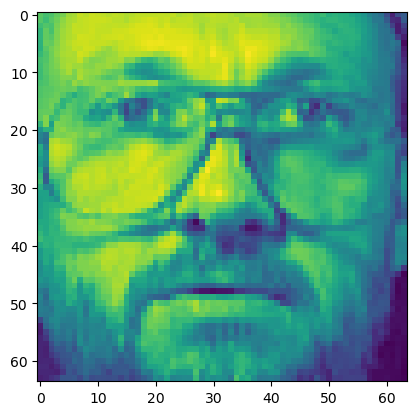

In [3]:
plt.imshow(faces[0].reshape(64,64))

In [69]:
def compute_principal_components(data, n_components):    
    ### YOUR CODE HERE
    # Subtract the mean of each feature
    X=data
    mu = np.mean(X, axis=0)
    X_centered = (X - mu)
    # Calculate the covariance matrix
    cov_X = np.cov(X_centered.T)
    # Compute the eigenvectors and eigenvalues of the covariance matrix
    eigenVal, eigenVec= np.linalg.eigh(cov_X)

    # Sort the eigenvectors in descending order of their corresponding eigenvalues

    # Return the sorted eigenvectors, singular values, and mean of each feature    
    return eigenVec[:, -n_components:]


    
def project_pca(data, pc):
    ### YOUR CODE HERE
    X=data 
    mu = np.mean(X, axis=0)
    X_centered = X - mu
    pData = np.dot(X, pc)
    return pData
    

    
def unproject_pca(proj_data, pc):
    ### YOUR CODE HERE    
    return np.dot(proj_data,pc.T)
    

In [70]:
n_comps = 2
pc = compute_principal_components(faces, n_comps)
proj_faces = project_pca(faces, pc)
rec_faces = unproject_pca(proj_faces, pc)
assert pc.shape == (faces.shape[-1], n_comps)
assert proj_faces.shape == (faces.shape[0], n_comps)
assert rec_faces.shape == faces.shape

In [107]:
proj_faces.shape

(2, 400)

In [95]:
faces.shape[-1]

4096

In [120]:
rec_faces.shape

(400, 4096)

In [121]:
faces.shape

(400, 4096)

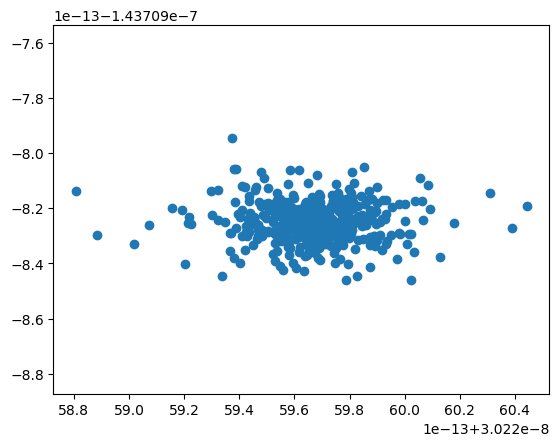

In [10]:
plt.scatter(proj_faces[:,0], proj_faces[:,1])
_ = plt.axis('equal')

In [122]:
print(rec_faces[0].dtype)

complex128


In [138]:
print(centered_faces[0].dtype)

float32


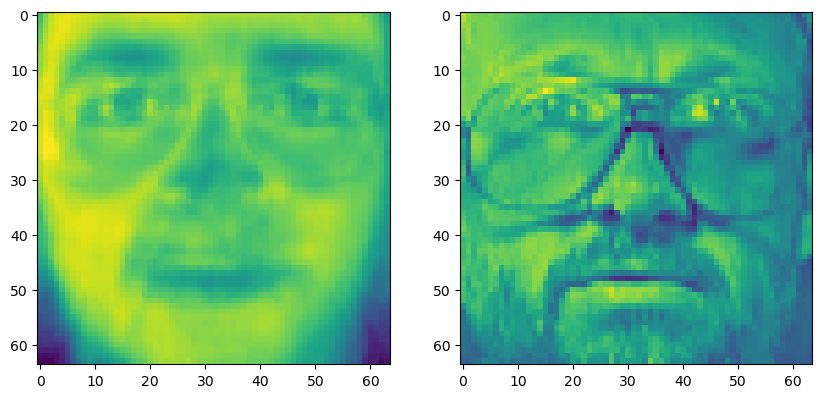

In [71]:
fig, axes = plt.subplots(1,2, figsize=(10,10*2), sharex=True)
centered_faces = faces - faces.mean(0)


axes[0].imshow(rec_faces[0].astype(float).reshape(64,64))
axes[1].imshow(centered_faces[0].reshape(64,64))

## MDS
For MDS (and IsoMap) you will compute 2D embeddings of the 3D S dataset shown below. To this end implement the `mds` function that takes a Euclidean distance matrix as input and the number of dimensions of the lower dimensional embedding space (i.e. `n_comps`). For a 2D plot choose `n_comps = 2`. To compute the eigendecomposition you can use `np.linalg.eigh` (see the documentation [here](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)). To construct an identity matrix use `np.eye`. To generate a constant one matrix use `np.ones` or `np.ones_like`. For other mathematical operations you might need refer to the numpy documentation.

The colors are added to the 3D and 2D scatter plots to make it easier for you to verify your results.

In [20]:
colors = k3d.helpers.map_colors(s_curve[:,-1], k3d.colormaps.matplotlib_color_maps.viridis).astype(np.uint32)
k3d.points(s_curve.astype(np.float32), colors=colors, point_size=0.1)

Output()

In [19]:
s_curve = np.load("s.npy")

In [12]:
s_curve

array([[ 0.68330147,  0.70067626, -0.26986364],
       [-0.87426925,  1.8509231 , -1.48544133],
       [-0.38052961,  1.96689595,  0.07523127],
       ...,
       [ 0.69937753,  0.26100497, -0.28524755],
       [ 0.68895925,  0.6459453 ,  1.72480007],
       [ 0.99996023,  1.15313735, -0.99108124]])

We can compute the Euclidean distance matrix for the 3D points like this:

In [21]:
dists = cdist(s_curve, s_curve, 'euclidean')
dists.shape

(500, 500)

In [63]:
def mds(dists, n_comps):
    ### YOUR CODE HERE
    
    # Calculate squared distance matrix
    D = np.square(dists)

    # Center similarity matrix
    n = D.shape[0]
    I = np.identity(n)
    one = np.ones((n, n))
    J = I - (1/n) * one
    B = -0.5 * J @ D @ J

    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(B)

    eigenvalues = eigenvalues[-n_comps:]
    eigenvectors = eigenvectors[:, -n_comps:]
    
    # Construct low-dimensional representation
    Y = eigenvectors * np.sqrt(eigenvalues)
    return Y


In [64]:
s_emb = mds(dists, 2)
assert s_emb.shape == (dists.shape[0], 2)

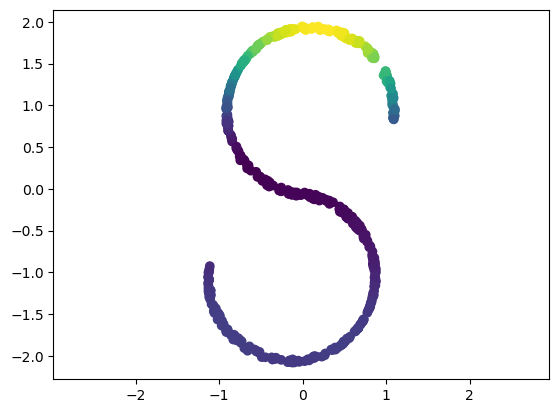

In [65]:
plt.scatter(s_emb[:,0], s_emb[:,1], c=colors)
_ = plt.axis('equal')

## IsoMap
We will now apply IsoMap to the same S 3D dataset and compute a 2D embedding. The shortest path distance matrix can be computed for the pairwise graph distances on a neighbourhood graph with the given `shortest_path_dists` function. It takes the previously computed Euclidean distance matrix and a `eps` value that determines if points are connected by an edge or not. We recommend for you to set `eps = 0.35`. 

In [66]:
def shortest_path_dists(dists, eps=0.35):
    rows = []
    cols = []
    data = []
    for i in range(dists.shape[0]):
        for j in range(i+1, dists.shape[0]):
            if dists[i,j] <= eps:
                rows.append(i)
                cols.append(j)
                data.append(dists[i,j])
                rows.append(j)
                cols.append(i)
                data.append(dists[i,j])
    adj_matrix = csr_matrix((data, (rows, cols)), shape=dists.shape)
    path_dists = shortest_path(adj_matrix, directed=False)
    return path_dists

def isomap(dists, n_comps):
    D = dists
    ### YOUR CODE HERE
    # Find the k-nearest neighbors for each point   
    # Get the indices of the k smallest values in each row
    k = 2000
    knn_indices = np.argsort(dists, axis=1)[:, :k]        

    # Construct the neighborhood graph
    N = np.zeros((dists.shape[0], dists.shape[0]))
    for i in range(dists.shape[0]):
        N[i, knn_indices[i]] = D[i, knn_indices[i]]
        N[knn_indices[i], i] = D[knn_indices[i], i]
    
    dist_matrix =shortest_path_dists(N)
    return mds(dist_matrix ,2)
    

In [67]:
s_emb_iso = isomap(dists, 2)
assert s_emb_iso.shape == (dists.shape[0], 2)

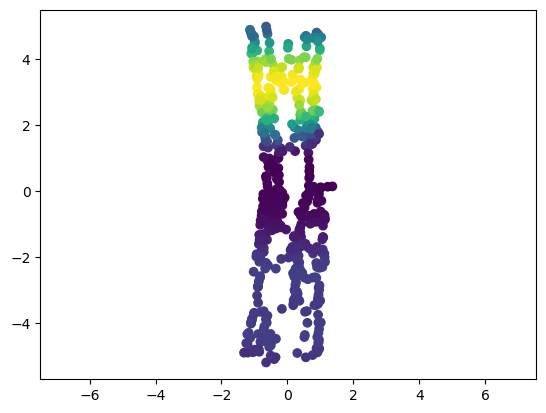

In [68]:
plt.scatter(s_emb_iso[:,0], s_emb_iso[:,1], c=colors)
_ = plt.axis('equal')